# **Uczenie nadzorowane**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### **Pobranie danych**

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data'
names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PIRATIO', 'B', 'LSTAT', 'MEDV']
data = pd.read_csv(url, delim_whitespace=True, names=names)
#delim_whitespace - wczytuje kolumny oddzielone dowolnym białym znakiem (spacje, tab itp.)
#names - ręczne określenie nazw kolumn
data.head()

C:\Users\1\AppData\Local\Temp\ipykernel_20872\3220783389.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(url, delim_whitespace=True, names=names)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PIRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


### **EDA**

In [3]:
data.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PIRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [4]:
data.isna().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PIRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

In [5]:
# CHAS kategoryczna

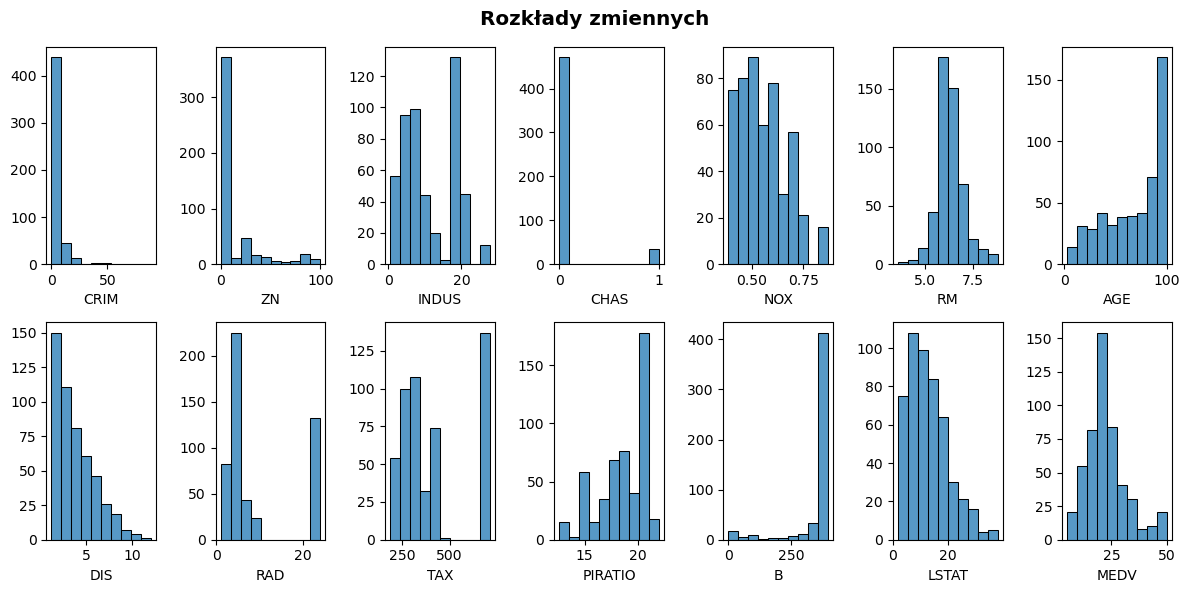

In [6]:
fig, ax = plt.subplots(2, 7, figsize=(12, 6))
ax = ax.flatten()
index = 0
for col in data.columns:
    if col == 'CHAS':
        sns.histplot(data=data, x=col, ax=ax[index])
        ax[index].set_ylabel('')
        index += 1
        continue
    #reguła Freedmana i Diaconisa
    #q1 = data[col].quantile(0.25)
    #q3 = data[col].quantile(0.75)
    #iqr = q3 - q1
    #W = (2*iqr) / (len(data[col])**(1/3))
    #N = int(np.ceil(data[col].max() - data[col].min()) / W)

    #reguła Sturge'a
    bin_count = int(np.ceil(np.log2(len(data[col])))+1)
    sns.histplot(data=data, x=col, ax=ax[index], bins=bin_count)
    ax[index].set_ylabel('')
    index += 1

plt.suptitle('Rozkłady zmiennych', fontsize='x-large', fontweight='bold')
plt.tight_layout()
plt.show()

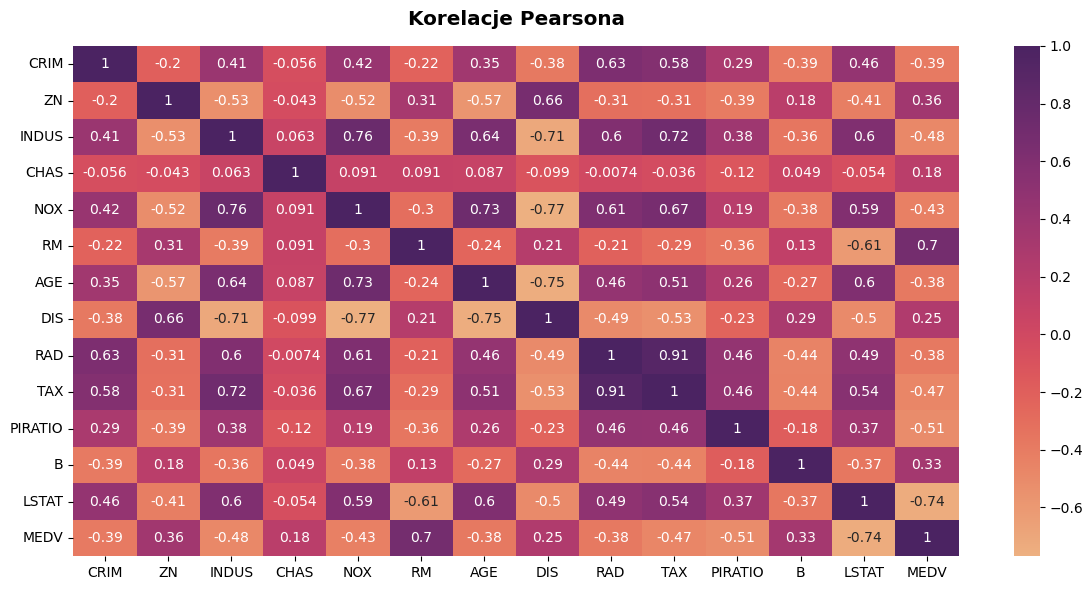

In [7]:
plt.figure(figsize=(12, 6))
sns.heatmap(data.corr(), cmap='flare', annot=True)
plt.title('Korelacje Pearsona', fontsize='x-large', fontweight='bold', pad=15)
plt.tight_layout()
plt.show()

### **Train-Test Split**

In [8]:
X = data.drop('MEDV', axis=1) # axis=1 - drop labels from columns
y = data['MEDV']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

### **Reresja liniowa**

In [9]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

### **XGBoost**
`objective='reg:squarederror'` - mówi modelowi, że ma minimalizować MSE

`colsample_bytree=0.3` - model losowo wybiera 30% kolumn przy budowie drzewa, zapobiega to przeuczeniu

`estimator=xg_reg` - model, który będzie dopasowywany do danych

`param_grid=params` - zestaw parametrów do przetestowania

`cv=5` - 5-krotna walidacja krzyżowa, dane dzielone są na 5 części, a model sprawdzany jest na każdej z nich, co zwiększa różnorodność

`scoring='neg_mean_squared_error'` - metryka oceny modelu, *GridSearchCV* domyślnie chce maksymalizować wynik, dlatego błąd jest podawany ze znakiem minus

In [10]:
params = {'learning_rate': [0.01, 0.1, 0.3], 'max_depth': [3, 5, 7], 'n_estimators': [50, 100, 200]}
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3)
xg_reg.fit(X_train, y_train)

grid = GridSearchCV(estimator=xg_reg, param_grid=params, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

print('Best score: %f using params: %s' % (grid.best_score_, grid.best_params_))

Best score: -10.565142 using params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}


In [11]:
y_pred_lr = lr.predict(X_test)
y_pred_xgb = grid.best_estimator_.predict(X_test)

### **Ocena modeli**

In [12]:
print('Regresja liniowa:')
print('MSE : ', mean_squared_error(y_test, y_pred_lr))
print('MAE : ', mean_absolute_error(y_test, y_pred_lr))
print('R2 : ', r2_score(y_test, y_pred_lr))
print('-----------')
print('XGBoost:')
print('MSE : ', mean_squared_error(y_test, y_pred_xgb))
print('MAE : ', mean_absolute_error(y_test, y_pred_xgb))
print('R2 : ', r2_score(y_test, y_pred_xgb))

Regresja liniowa:
MSE :  34.41396845313861
MAE :  4.061419182954713
R2 :  0.6709339839115624
-----------
XGBoost:
MSE :  15.574878081707979
MAE :  2.738736495784685
R2 :  0.8510731743016011


In [13]:
y_test = y_test.to_numpy()

## **Założenia regresji liniowej**

#### **Liniowość**
Związek między zmiennymi niezależnymi i zmienną zależną jest liniowy.
$$ y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_n x_n + \epsilon $$


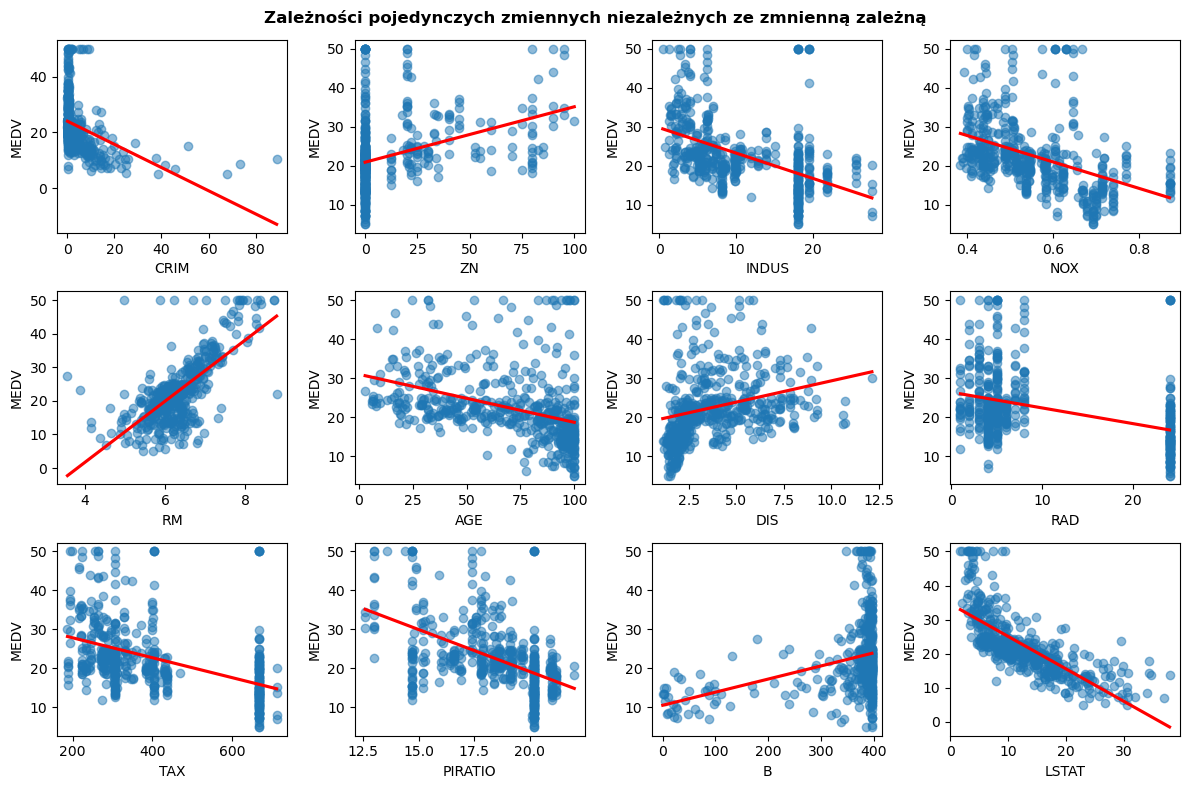

In [14]:
chart_df = data.drop(['CHAS', 'MEDV'], axis=1)
fig, ax = plt.subplots(3, 4, figsize=(12, 8))
ax = ax.flatten()
for i, col in enumerate(chart_df.columns):
    ax[i].scatter(chart_df[col], data['MEDV'], alpha=0.5)
    sns.regplot(x=chart_df[col], y=data['MEDV'],
                scatter=False,
                color='red',
                ci=None, #confidence interval
                ax=ax[i])

plt.suptitle('Zależności pojedynczych zmiennych niezależnych ze zmnienną zależną', fontweight='bold')
plt.tight_layout()
plt.show()

**Wykres rzeczywistych wartości i predykcji powinien ułożyć się wokół prostej.**

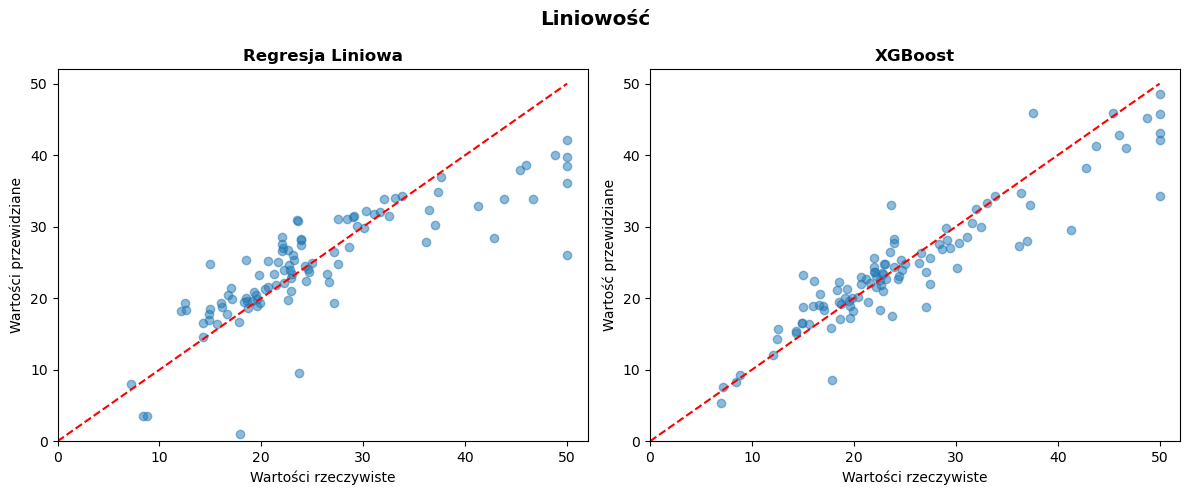

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].scatter(y_test, y_pred_lr, alpha=0.5)
ax[0].plot([0, y_test.max()], [0, y_test.max()], color='red', linestyle='--')
ax[0].set_xlim([0, y_test.max() + 2]); ax[0].set_ylim([0, y_test.max() + 2])
ax[0].set_title('Regresja Liniowa', fontweight='bold'); ax[0].set_xlabel('Wartości rzeczywiste'); ax[0].set_ylabel('Wartości przewidziane')

ax[1].scatter(y_test, y_pred_xgb, alpha=0.5)
ax[1].plot([0, y_test.max()], [0, y_test.max()], color='red', linestyle='--')
ax[1].set_xlim([0, y_test.max() + 2]); ax[1].set_ylim([0, y_test.max() + 2])
ax[1].set_title('XGBoost', fontweight='bold'); ax[1].set_xlabel('Wartości rzeczywiste'); ax[1].set_ylabel('Wartość przewidziane')

fig.suptitle('Liniowość', fontsize='x-large', fontweight='bold')
plt.tight_layout()
plt.show()

### **Homoskedastyczność**
Wariancja reszt jest stała dla wszystkich wartości predyktorów (reszta-różnica między wartością rzeczywistą, a przewidzianą). Oznacza to, że błędy modelu nie stają się większe ani mniejsze w zależności od tego, co przewiduje model, więc ich rozproszenie jest mniej więcej takie samo w całym zakresie danych.

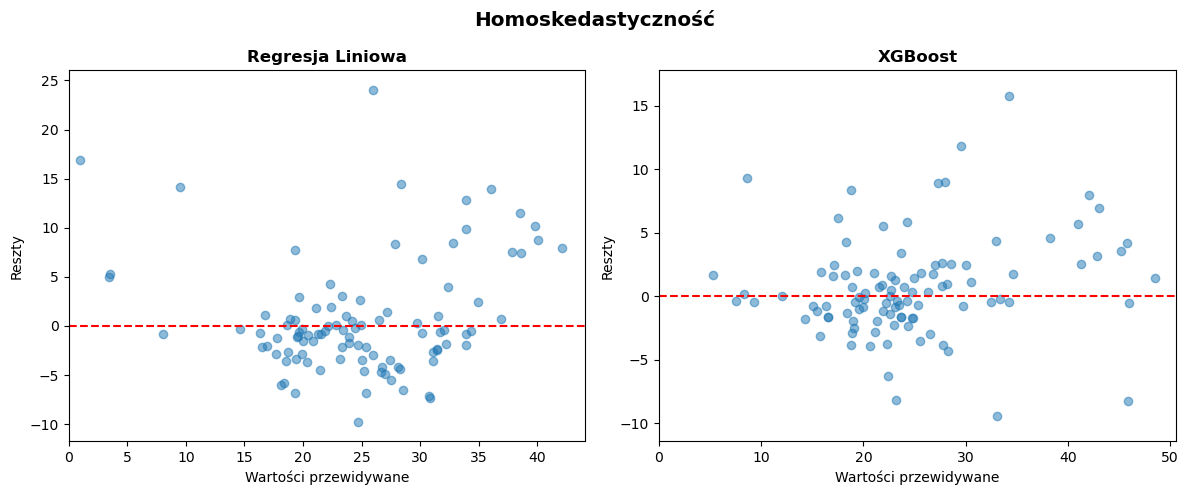

In [16]:
residuals_lr = y_test - y_pred_lr
residuals_xgb = y_test - y_pred_xgb

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].scatter(y_pred_lr, residuals_lr, alpha=0.5)
ax[0].axhline(y=0, color='red', linestyle='--')
ax[0].set_xlim([0, y_pred_lr.max() + 2]); ax[0].set_ylim([residuals_lr.min() - 2, residuals_lr.max() + 2])
ax[0].set_title('Regresja Liniowa', fontweight='bold'); ax[0].set_xlabel('Wartości przewidywane'); ax[0].set_ylabel('Reszty')

ax[1].scatter(y_pred_xgb, residuals_xgb, alpha=0.5)
ax[1].axhline(y=0, color='red', linestyle='--')
ax[1].set_xlim([0, y_pred_xgb.max() + 2]); ax[1].set_ylim([residuals_xgb.min() - 2, residuals_xgb.max() + 2])
ax[1].set_title('XGBoost', fontweight='bold'); ax[1].set_xlabel('Wartości przewidywane'); ax[1].set_ylabel('Reszty')

fig.suptitle('Homoskedastyczność', fontsize='x-large', fontweight='bold')
plt.tight_layout()
plt.show()

#### **Homoskedastyczność - Test Breuscha-Pagana**
Test Breuscha-Pagana to statystyczny test używany do sprawdzenia czy w modelu regresji liniowej spełnione jest założenie homoskedastyczności.

p-value > 0.05 : Homoskedastyczność spełniona

p-value ≤ 0.05 : Homoskedastyczność niespełniona (heteroskedastyczność)



In [17]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

X_test_with_const = sm.add_constant(X_test)

model_lr = sm.OLS(y_test, X_test_with_const).fit()
bp_test_lr = het_breuschpagan(model_lr.resid, model_lr.model.exog)
p_value_lr = bp_test_lr[1]

model_xgb_resid = sm.OLS(residuals_xgb**2, X_test_with_const).fit()
bp_test_xgb = het_breuschpagan(model_xgb_resid.resid, X_test_with_const)
p_value_xgb = bp_test_xgb[1]

print(f"p-value Breuscha-Pagana - Regresja liniowa: {p_value_lr}")
print(f"p-value Breuscha-Pagana - XGBoost: {p_value_xgb}")

p-value Breuscha-Pagana - Regresja liniowa: 0.025435840743577735
p-value Breuscha-Pagana - XGBoost: 0.020673132011131665


### **Normalność reszt**
Reszty mają rozkład normalny.

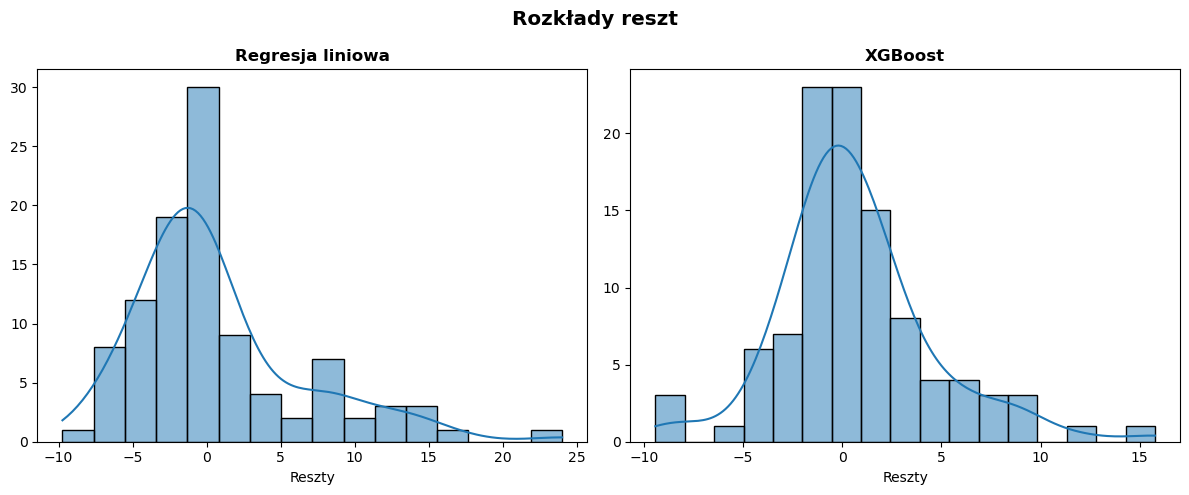

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

#bin_count = int(np.ceil(np.log2(len(residuals_lr)))+1)
sns.histplot(residuals_lr, kde=True, ax=ax[0])
ax[0].set_title('Regresja liniowa', fontweight='bold')
ax[0].set_xlabel('Reszty')
ax[0].set_ylabel('')

sns.histplot(residuals_xgb, kde=True, ax=ax[1])
ax[1].set_title('XGBoost', fontweight='bold')
ax[1].set_xlabel('Reszty')
ax[1].set_ylabel('')

plt.suptitle('Rozkłady reszt', fontsize='x-large', fontweight='bold')
plt.tight_layout()
plt.show()

#### **Normalnośc reszt - test Shapiro-Wilka**
Test Shapiro-Wilka sprawdza czy dane mają rozkład normalny.

p-value > 0.05 : Reszty mają rozkład normalny

p-value ≤ 0.05 : Reszty nie mają rozkładu normalnego

In [19]:
from scipy.stats import shapiro
stat_lr, p_value_lr = shapiro(residuals_lr)
print(f"p-value Shapiro-Wilka - Regresja liniowa: {p_value_lr}")
stat_xgb, p_value_xgb = shapiro(residuals_xgb)
print(f"p-value Shapiro-Wilka - XGBoost: {p_value_xgb}")

p-value Shapiro-Wilka - Regresja liniowa: 2.688387338932808e-07
p-value Shapiro-Wilka - XGBoost: 0.00012542798510880104


### **Podsumowanie**
Analiza tych założeń wykazała, że modele nie spełniają założeń dla regresji liniowej. Oznacza to, że wyniki mogą być niewiarygodne, a wyciągnięte wnioski błędne.